# 注意力可视化

In [1]:
import torch
from d2l import torch as d2l

In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

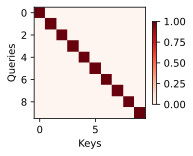

In [4]:
# 创建 10*10的单位矩阵，主对角线值是1
# 演示可视化工具，即对矩阵可视化，越靠近1颜色越深
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# 注意力汇聚：Nadaraya-Watson 核回归

>实现这个f(x)函数，即输入x得到被其他xi影响后的x

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
# 生成数据集 yi = 2sinxi + xi + 噪声
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本
# x为50个0-5中间的值
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本 50个
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [8]:
# 下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数 f（标记为“Truth”）
# 以及学习得到的预测函数（标记为“Pred”）
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

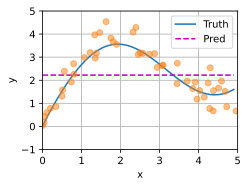

In [10]:
# 平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

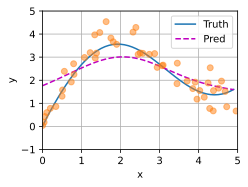

In [15]:
# 非参数注意力汇聚
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
# X_repeat是50*50的结果，X_repeat - x_train 结果是X_repeat第一行50个元素挨个和x_train相减
# 这就相当于 X_test的50个元素，每个元素都和x_train的50个元素做了减法
# 然后再softmax等计算，得到相当于每个元素被x_train的50个元素影响后的结果权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

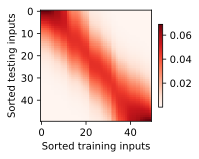

In [16]:
# 查看注意力权重矩阵
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 带参数注意力汇聚

In [17]:
#假定两个张量的形状分别是 n,a,b和 n,b,c 它们的批量矩阵乘法输出的形状为 n,a,c
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [20]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [21]:
# 带参数的核模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [ ]:
# 训练


# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
# 这行代码的作用是从张量`X_tile`中选取特定元素，并进行形状调整。
# 首先，`torch.eye(n_train)`会创建一个大小为`n_train`×`n_train`的单位矩阵。
# 接着，`1 - torch.eye(n_train)`会将单位矩阵中的元素取反，即非对角线上的元素变为 1，对角线上的元素变为 0。
# 然后，`.type(torch.bool)`将结果转换为布尔类型的张量。
# `X_tile[(1 - torch.eye(n_train)).type(torch.bool)]`
# 通过布尔索引从`X_tile`中选取那些对应位置为真（即非对角线上的位置）的元素。
# 最后，`.reshape((n_train, -1))`将选取出来的元素重新调整形状为`n_train`行，列数自动计算以容纳所有选取的元素。
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

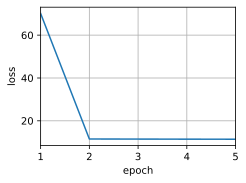

In [26]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

# 本质上这个训练就是，50个点对应50个结果，每次取一个点，得到这个点和所有其他点的关联性关系矩阵，这个矩阵再乘其他所有点的y结果
# 就是这个点的预测结果，预测结果和真实结果再做对比，再loss
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

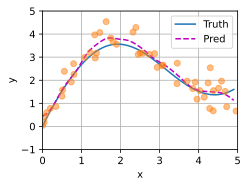

In [27]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

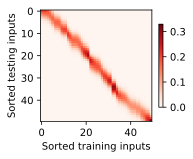

In [28]:
# 看一下注意力权重
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')